## Consolidate Financial and Macroeconomic Data

In [12]:
import pandas as pd
import os

# --- Configuration ---
DATA_FOLDER = "data"
FINANCIAL_FILES = {
    'sp500': os.path.join(DATA_FOLDER, 's&p_500_daily.csv'),
    'nasdaq': os.path.join(DATA_FOLDER, 'nasdaq_daily.csv'),
    'ftse100': os.path.join(DATA_FOLDER, 'ftse_100_daily.csv')
}
MACRO_FILES = {
    'gdp': os.path.join(DATA_FOLDER, 'macro_gdp.csv'),
    'inflation': os.path.join(DATA_FOLDER, 'macro_inflation_cpi.csv'),
    'unemployment': os.path.join(DATA_FOLDER, 'macro_unemploymentrate.csv'),
    'vix': os.path.join(DATA_FOLDER, 'macro_vix.csv')
}

# --- Load and Combine Data ---

# Load the primary financial index (e.g., S&P 500)
# The CSV structure: Row 1=headers, Row 2=tickers, Row 3=Date placeholder, Row 4+=data
# We need to skip rows 1 and 2, then use column 0 (Price) as the date index
df_master = pd.read_csv(FINANCIAL_FILES['sp500'], skiprows=[1, 2], index_col=0, parse_dates=True)

# Rename the index to something more meaningful
df_master.index.name = 'Date'

# Select and rename key columns to avoid confusion
df_master = df_master[['Open', 'High', 'Low', 'Close', 'Volume']].add_prefix('sp500_')

# Load and merge other financial indices
for name, path in FINANCIAL_FILES.items():
    if name != 'sp500':
        df_temp = pd.read_csv(path, skiprows=[1, 2], index_col=0, parse_dates=True)
        df_temp.index.name = 'Date'
        df_master = df_master.merge(
            df_temp[['Close', 'Volume']].add_prefix(f'{name}_'),
            left_index=True,
            right_index=True,
            how='left'
        )

# Load and merge macroeconomic data
for name, path in MACRO_FILES.items():
    try:
        df_macro = pd.read_csv(path, index_col='DATE', parse_dates=True)
        # Rename the column to be specific
        df_macro.rename(columns={df_macro.columns[0]: f'macro_{name}'}, inplace=True)
        df_master = df_master.merge(df_macro, left_index=True, right_index=True, how='left')
    except FileNotFoundError:
        print(f"Warning: {path} not found, skipping {name} data")

# --- Clean and Preprocess ---

# Forward-fill the macroeconomic data to fill daily gaps
macro_cols = [col for col in df_master.columns if 'macro_' in col]
if macro_cols:
    df_master[macro_cols] = df_master[macro_cols].ffill()

# Use interpolation for any remaining gaps (e.g., in stock data on holidays)
df_master.interpolate(method='time', inplace=True)

# Drop any rows that still have missing values (typically at the very beginning)
df_master.dropna(inplace=True)

print("✅ Master DataFrame created successfully!")
print("Shape of the data:", df_master.shape)
print("\nColumn names:")
print(df_master.columns.tolist())
print("\nFirst 5 rows:")
print(df_master.head())
print("\nLast 5 rows:")
print(df_master.tail())
print("\nData types:")
print(df_master.dtypes)
print("\nDate range:")
print(f"From: {df_master.index.min()} To: {df_master.index.max()}")

✅ Master DataFrame created successfully!
Shape of the data: (2577, 13)

Column names:
['sp500_Open', 'sp500_High', 'sp500_Low', 'sp500_Close', 'sp500_Volume', 'nasdaq_Close', 'nasdaq_Volume', 'ftse100_Close', 'ftse100_Volume', 'macro_gdp', 'macro_inflation', 'macro_unemployment', 'macro_vix']

First 5 rows:
             sp500_Open   sp500_High    sp500_Low  sp500_Close  sp500_Volume  \
Date                                                                           
2015-04-01  2067.629883  2067.629883  2048.379883  2059.689941    3543270000   
2015-04-02  2060.030029  2072.169922  2057.320068  2066.959961    3095960000   
2015-04-06  2064.870117  2086.989990  2056.520020  2080.620117    3302970000   
2015-04-07  2080.790039  2089.810059  2076.100098  2076.330078    3065510000   
2015-04-08  2076.939941  2086.689941  2073.300049  2081.899902    3265330000   

            nasdaq_Close  nasdaq_Volume  ftse100_Close  ftse100_Volume  \
Date                                                    

## Process GDELT Data to Create Sentiment Features

In [13]:
import pandas as pd
import numpy as np

# --- Load GDELT Data ---
gdelt_path = 'data/gdelt_usa_10year_raw.csv'
print(f"Loading GDELT data from {gdelt_path}...")
df_gdelt = pd.read_csv(gdelt_path)

print(f"GDELT data shape: {df_gdelt.shape}")

# --- Parse Sentiment from V2Tone ---
def parse_v2tone_quick(v2tone_str):
    """A robust function to parse the V2Tone string."""
    try:
        # The first value is the average tone
        return float(str(v2tone_str).split(',')[0])
    except (ValueError, IndexError):
        return np.nan # Return NaN if parsing fails

df_gdelt['tone_avg'] = df_gdelt['V2Tone'].apply(parse_v2tone_quick)

# --- Aggregate Sentiment by Day ---
# Convert DATE column to datetime objects
df_gdelt['date_only'] = pd.to_datetime(df_gdelt['DATE'], format='%Y%m%d%H%M%S').dt.date

# Calculate the mean sentiment for each day
daily_sentiment = df_gdelt.groupby('date_only')['tone_avg'].mean().to_frame(name='gdelt_sentiment')
daily_sentiment.index = pd.to_datetime(daily_sentiment.index)

print(f"Daily sentiment shape: {daily_sentiment.shape}")
print(f"Daily sentiment date range: {daily_sentiment.index.min()} to {daily_sentiment.index.max()}")

# --- Clean existing sentiment columns if they exist ---
sentiment_cols = [col for col in df_master.columns if 'gdelt_sentiment' in col]
if sentiment_cols:
    print(f"Removing existing sentiment columns: {sentiment_cols}")
    df_master = df_master.drop(columns=sentiment_cols)

# --- Merge into Master DataFrame ---
print(f"Master DataFrame shape before merge: {df_master.shape}")
df_master = df_master.merge(daily_sentiment, left_index=True, right_index=True, how='left')
print(f"Master DataFrame shape after merge: {df_master.shape}")

# Fill weekends/holidays with the last known sentiment value
df_master['gdelt_sentiment'] = df_master['gdelt_sentiment'].ffill()

# Fill any remaining initial NaNs with 0 (neutral)
df_master['gdelt_sentiment'] = df_master['gdelt_sentiment'].fillna(0)

print("✅ GDELT sentiment successfully merged into master DataFrame!")
print("Final shape:", df_master.shape)
print("\nColumn names:")
print(df_master.columns.tolist())
print("\nSample data with sentiment:")
print(df_master[['sp500_Close', 'gdelt_sentiment']].tail())
print(f"\nSentiment statistics:")
print(f"Mean: {df_master['gdelt_sentiment'].mean():.3f}")
print(f"Std: {df_master['gdelt_sentiment'].std():.3f}")
print(f"Min: {df_master['gdelt_sentiment'].min():.3f}")
print(f"Max: {df_master['gdelt_sentiment'].max():.3f}")
print(f"Missing values: {df_master['gdelt_sentiment'].isna().sum()}")

Loading GDELT data from data/gdelt_usa_10year_raw.csv...
GDELT data shape: (106058, 37)
Daily sentiment shape: (3461, 1)
Daily sentiment date range: 2015-03-01 00:00:00 to 2025-06-12 00:00:00
Master DataFrame shape before merge: (2577, 13)
Master DataFrame shape after merge: (2577, 14)
✅ GDELT sentiment successfully merged into master DataFrame!
Final shape: (2577, 14)

Column names:
['sp500_Open', 'sp500_High', 'sp500_Low', 'sp500_Close', 'sp500_Volume', 'nasdaq_Close', 'nasdaq_Volume', 'ftse100_Close', 'ftse100_Volume', 'macro_gdp', 'macro_inflation', 'macro_unemployment', 'macro_vix', 'gdelt_sentiment']

Sample data with sentiment:
            sp500_Close  gdelt_sentiment
Date                                    
2025-06-24  6092.180176        -2.529748
2025-06-25  6092.160156        -2.529748
2025-06-26  6141.020020        -2.529748
2025-06-27  6173.069824        -2.529748
2025-06-30  6204.950195        -2.529748

Sentiment statistics:
Mean: -2.213
Std: 0.789
Min: -6.578
Max: 2.809


## Final Dataset Summary

In [15]:
# Final verification and summary of the consolidated dataset
print("="*60)
print("FINAL DATASET SUMMARY")
print("="*60)

print(f"📊 Dataset Shape: {df_master.shape[0]:,} rows × {df_master.shape[1]} columns")
print(f"📅 Date Range: {df_master.index.min().strftime('%Y-%m-%d')} to {df_master.index.max().strftime('%Y-%m-%d')}")
print(f"⏱️  Duration: {(df_master.index.max() - df_master.index.min()).days:,} days")

print("\n📈 Data Categories:")
financial_cols = [col for col in df_master.columns if any(x in col for x in ['sp500', 'nasdaq', 'ftse'])]
macro_cols = [col for col in df_master.columns if 'macro_' in col]
sentiment_cols = [col for col in df_master.columns if 'gdelt' in col]

print(f"  • Financial Data: {len(financial_cols)} columns")
print(f"  • Macroeconomic Data: {len(macro_cols)} columns") 
print(f"  • Sentiment Data: {len(sentiment_cols)} columns")

print("\n🔍 Data Quality Check:")
print(f"  • Total missing values: {df_master.isnull().sum().sum()}")
print(f"  • Rows with any missing values: {df_master.isnull().any(axis=1).sum()}")

print("\n📋 Column Summary:")
for i, col in enumerate(df_master.columns, 1):
    missing = df_master[col].isnull().sum()
    print(f"  {i:2}. {col:<20} - Missing: {missing:4} ({missing/len(df_master)*100:.1f}%)")

print("\n✅ Dataset is ready for modeling and analysis!")
print("="*60)

FINAL DATASET SUMMARY
📊 Dataset Shape: 2,577 rows × 14 columns
📅 Date Range: 2015-04-01 to 2025-06-30
⏱️  Duration: 3,743 days

📈 Data Categories:
  • Financial Data: 9 columns
  • Macroeconomic Data: 4 columns
  • Sentiment Data: 1 columns

🔍 Data Quality Check:
  • Total missing values: 0
  • Rows with any missing values: 0

📋 Column Summary:
   1. sp500_Open           - Missing:    0 (0.0%)
   2. sp500_High           - Missing:    0 (0.0%)
   3. sp500_Low            - Missing:    0 (0.0%)
   4. sp500_Close          - Missing:    0 (0.0%)
   5. sp500_Volume         - Missing:    0 (0.0%)
   6. nasdaq_Close         - Missing:    0 (0.0%)
   7. nasdaq_Volume        - Missing:    0 (0.0%)
   8. ftse100_Close        - Missing:    0 (0.0%)
   9. ftse100_Volume       - Missing:    0 (0.0%)
  10. macro_gdp            - Missing:    0 (0.0%)
  11. macro_inflation      - Missing:    0 (0.0%)
  12. macro_unemployment   - Missing:    0 (0.0%)
  13. macro_vix            - Missing:    0 (0.0%)
  1

## Create Time-Series & Crisis Features

In [16]:
import pandas as pd

# This assumes your master dataframe is named df_master

# --- Create Time-Series Features ---
# Moving Averages for the S&P 500 close price
df_master['sp500_ma_7'] = df_master['sp500_Close'].rolling(window=7).mean()
df_master['sp500_ma_30'] = df_master['sp500_Close'].rolling(window=30).mean()

# Lagged Values for the S&P 500 close price
for i in range(1, 4): # Create 3 lag features (t-1, t-2, t-3)
    df_master[f'sp500_lag_{i}'] = df_master['sp500_Close'].shift(i)

# --- Label Crisis Periods ---
# Define crisis periods (start_date, end_date)
# Using dates from your proposal [cite: 351, 402]
crisis_periods = {
    '2015_China_Market_Crash': ('2015-06-15', '2016-02-11'),
    '2018_Volatility': ('2018-10-01', '2018-12-31'),
    'COVID_Crash': ('2020-02-19', '2020-03-23'),
    '2022_Inflation_Crash': ('2022-01-01', '2022-12-31')
}

# Create the 'is_crisis' column, initialized to 0
df_master['is_crisis'] = 0

for crisis, (start, end) in crisis_periods.items():
    df_master.loc[start:end, 'is_crisis'] = 1

# Clean up by dropping initial rows with NaNs from lags/MA
df_master.dropna(inplace=True)

print("✅ Time-series and crisis features added!")
print("Number of crisis days labeled:", df_master['is_crisis'].sum())

# Show comprehensive date range information
print(f"\n📅 FULL DATASET DATE RANGE:")
print(f"   Start: {df_master.index.min().strftime('%Y-%m-%d')}")
print(f"   End: {df_master.index.max().strftime('%Y-%m-%d')}")
print(f"   Total days: {len(df_master):,}")

# Show first and last few rows to confirm full range
print(f"\n🔍 FIRST 3 ROWS (earliest dates):")
print(df_master[['sp500_Close', 'is_crisis']].head(3))

print(f"\n🔍 LAST 3 ROWS (latest dates):")
print(df_master[['sp500_Close', 'is_crisis']].tail(3))

# Show crisis period breakdown
print(f"\n📊 CRISIS PERIOD BREAKDOWN:")
for crisis, (start, end) in crisis_periods.items():
    crisis_data = df_master.loc[start:end] if start in df_master.index and end in df_master.index else pd.DataFrame()
    crisis_count = len(crisis_data)
    print(f"   {crisis}: {crisis_count} days ({start} to {end})")

print(f"\n📈 TOTAL CRISIS vs NON-CRISIS DAYS:")
crisis_counts = df_master['is_crisis'].value_counts()
print(f"   Non-Crisis (0): {crisis_counts.get(0, 0):,} days")
print(f"   Crisis (1): {crisis_counts.get(1, 0):,} days")

✅ Time-series and crisis features added!
Number of crisis days labeled: 506

📅 FULL DATASET DATE RANGE:
   Start: 2015-05-13
   End: 2025-06-30
   Total days: 2,548

🔍 FIRST 3 ROWS (earliest dates):
            sp500_Close  is_crisis
Date                              
2015-05-13  2098.479980          0
2015-05-14  2121.100098          0
2015-05-15  2122.729980          0

🔍 LAST 3 ROWS (latest dates):
            sp500_Close  is_crisis
Date                              
2025-06-26  6141.020020          0
2025-06-27  6173.069824          0
2025-06-30  6204.950195          0

📊 CRISIS PERIOD BREAKDOWN:
   2015_China_Market_Crash: 168 days (2015-06-15 to 2016-02-11)
   2018_Volatility: 63 days (2018-10-01 to 2018-12-31)
   COVID_Crash: 24 days (2020-02-19 to 2020-03-23)
   2022_Inflation_Crash: 0 days (2022-01-01 to 2022-12-31)

📈 TOTAL CRISIS vs NON-CRISIS DAYS:
   Non-Crisis (0): 2,042 days
   Crisis (1): 506 days


## Data Normalization & Final Prep


In [17]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# This assumes your fully-featured dataframe is named df_master

# Separate the target variable and the crisis flag
is_crisis_col = df_master['is_crisis']
# We scale features, not the crisis flag itself
features_to_scale = df_master.drop(columns=['is_crisis'])

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the features
scaled_features = scaler.fit_transform(features_to_scale)

# Create a new DataFrame with the scaled features
df_scaled = pd.DataFrame(scaled_features, index=df_master.index, columns=features_to_scale.columns)

# Add the 'is_crisis' column back to the scaled DataFrame
df_scaled['is_crisis'] = is_crisis_col

print("✅ Data successfully scaled!")
print("Shape of scaled data:", df_scaled.shape)
print("\nSample of scaled data:")
print(df_scaled.head())

df_scaled.to_csv('data/final_model_ready_data.csv')


✅ Data successfully scaled!
Shape of scaled data: (2548, 20)

Sample of scaled data:
            sp500_Open  sp500_High  sp500_Low  sp500_Close  sp500_Volume  \
Date                                                                       
2015-05-13    0.061060    0.060253   0.065509     0.061565      0.338220   
2015-05-14    0.061246    0.062831   0.066515     0.066734      0.323333   
2015-05-15    0.066209    0.063389   0.070268     0.067107      0.309936   
2015-05-18    0.066033    0.065196   0.071001     0.068585      0.289499   
2015-05-19    0.067902    0.065480   0.072030     0.068272      0.330379   

            nasdaq_Close  nasdaq_Volume  ftse100_Close  ftse100_Volume  \
Date                                                                     
2015-05-13      0.044393       0.010351       0.502621        0.211561   
2015-05-14      0.048684       0.011098       0.508635        0.160451   
2015-05-15      0.048529       0.010297       0.505423        0.187123   
2015-05-18  

## Visualize Key Relationships


### Plot Sentiment vs. Market Index

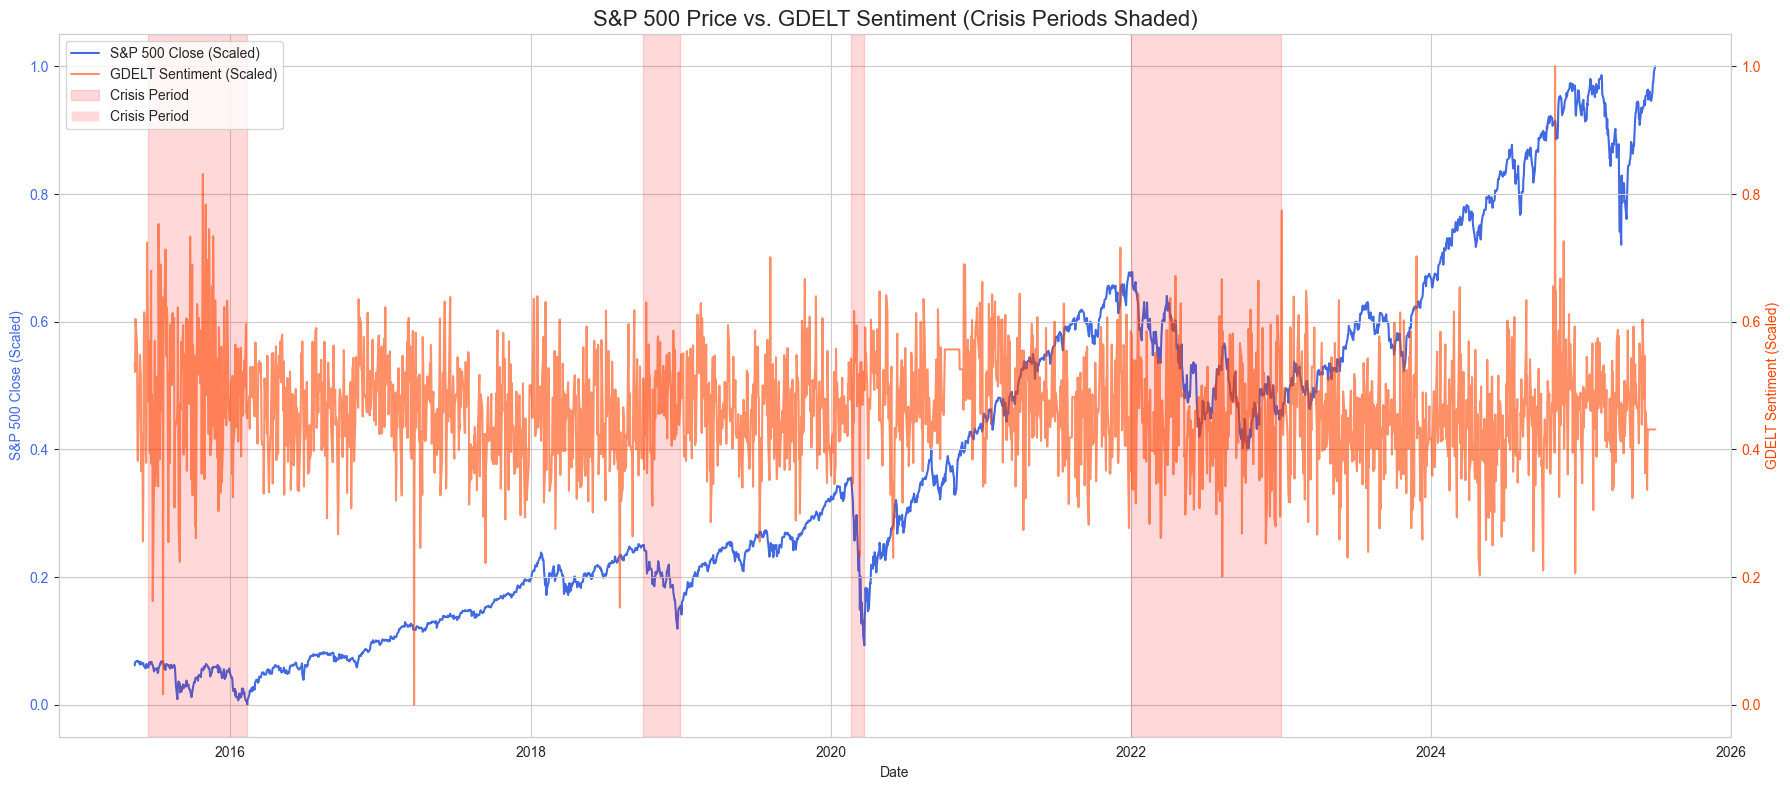

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional style for the plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8) # Wider plots

# Create the plot
fig, ax1 = plt.subplots()

# Plot S&P 500 Close price on the primary y-axis
ax1.plot(df_scaled.index, df_scaled['sp500_Close'], color='royalblue', label='S&P 500 Close (Scaled)')
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Close (Scaled)', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

# Create a secondary y-axis for the sentiment score
ax2 = ax1.twinx()
ax2.plot(df_scaled.index, df_scaled['gdelt_sentiment'], color='orangered', alpha=0.6, label='GDELT Sentiment (Scaled)')
ax2.set_ylabel('GDELT Sentiment (Scaled)', color='orangered')
ax2.tick_params(axis='y', labelcolor='orangered')

# --- Shade the Crisis Periods ---
for start, end in crisis_periods.values():
    plt.axvspan(start, end, color='red', alpha=0.15, label='Crisis Period' if 'crisis_label_added' not in locals() else "")
    # This ensures the label only appears once in the legend
    crisis_label_added = True


# --- Final Touches ---
plt.title('S&P 500 Price vs. GDELT Sentiment (Crisis Periods Shaded)', fontsize=16)
fig.tight_layout()
# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Manually add the crisis period label
from matplotlib.patches import Patch
legend_elements = lines + lines2 + [Patch(facecolor='red', alpha=0.15, label='Crisis Period')]
ax2.legend(handles=legend_elements, loc='upper left')

plt.show()

###  Compare Sentiment Distribution in Crisis vs. Non-Crisis Periods

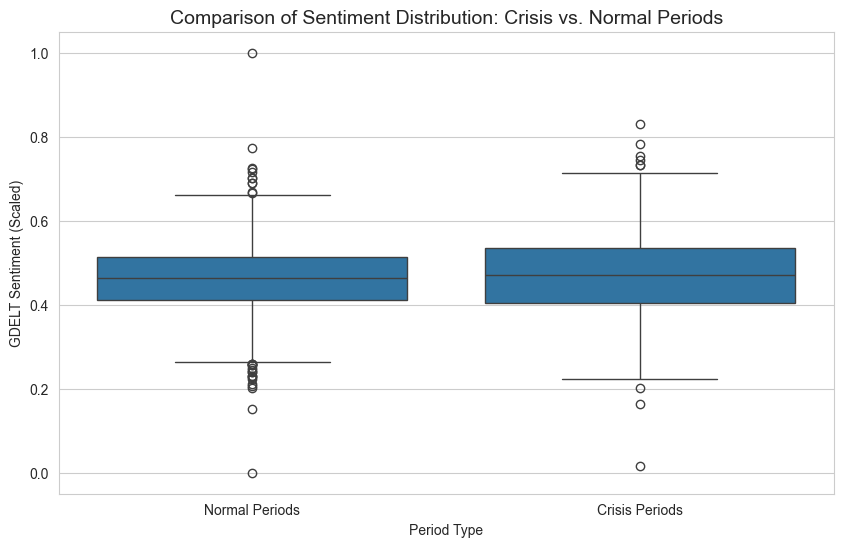

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 6) # Reset for a standard plot

# Create the box plot
sns.boxplot(x='is_crisis', y='gdelt_sentiment', data=df_scaled)

# Set labels and title
plt.xticks([0, 1], ['Normal Periods', 'Crisis Periods'])
plt.xlabel("Period Type")
plt.ylabel("GDELT Sentiment (Scaled)")
plt.title("Comparison of Sentiment Distribution: Crisis vs. Normal Periods", fontsize=14)

plt.show()

# Model Development 

## Split  Data for Training and Testing

In [15]:
import numpy as np

# This assumes your scaled, feature-rich DataFrame is named df_scaled

# --- Define the Target Variable ---
# We want to predict the next day's S&P 500 closing price
df_scaled['target'] = df_scaled['sp500_Close'].shift(-1)
df_scaled.dropna(inplace=True) # Drop the last row with a NaN target

# --- Split the Data Chronologically ---
# Define the split percentages
train_size = 0.70
validation_size = 0.15
# The rest will be the test set

# Calculate split indices
n = len(df_scaled)
train_end = int(n * train_size)
validation_end = int(n * (train_size + validation_size))

# Create the splits
df_train = df_scaled[:train_end]
df_val = df_scaled[train_end:validation_end]
df_test = df_scaled[validation_end:]

print("✅ Data split successfully!")
print(f"Training set size: {len(df_train)} ({len(df_train)/n:.0%})")
print(f"Validation set size: {len(df_val)} ({len(df_val)/n:.0%})")
print(f"Test set size: {len(df_test)} ({len(df_test)/n:.0%})")

# Separate features (X) and target (y) for each set
X_train = df_train.drop(columns='target')
y_train = df_train['target']

X_val = df_val.drop(columns='target')
y_val = df_val['target']

X_test = df_test.drop(columns='target')
y_test = df_test['target']

✅ Data split successfully!
Training set size: 1762 (70%)
Validation set size: 378 (15%)
Test set size: 378 (15%)


## Build a Baseline Model Moved to Colab

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Reshape Data for LSTM ---
# LSTM layers expect input in the shape: [samples, timesteps, features]
# We'll use 1 timestep for simplicity here.
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# --- Build the LSTM Model ---
baseline_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])

baseline_model.compile(optimizer='adam', loss='mean_squared_error')
print("\nBaseline LSTM Model Summary:")
baseline_model.summary()


# --- Train the Model ---
# Early stopping will prevent overfitting by monitoring validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = baseline_model.fit(
    X_train_lstm, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_lstm, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# --- Evaluate the Baseline Model ---
loss = baseline_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"\n✅ Baseline Model Trained. Test Loss (MSE): {loss:.6f}")

# --- Plot Training History ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'tensorflow'